# Getting started with `simple-scenario`

Initial imports and definitions

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
from pathlib import Path

result_dir = Path("results")

## Creating a *"slow lead object"* scenario

Let's say, we want to create a simple test scenario, where the ego vehicle is driving on a two-lane straight road at `80 km/h` and `50 m` in front of the ego, there is a slowly moving vehicle on the ego lane. The goal of the test scenario is to check, whether the ego vehicle is able to avoid a collision with the lead object and, in the best case, drive around it and continue driving at the starting speed. We want to execute the scenario in esmini.

Using `simple-scenario`, we can do that, in the following way:

In [2]:
from simple_scenario import Scenario, EgoConfiguration, Vehicle
from simple_scenario.road import Road, StraightSegment

# Create road
straight_road = Road(
    n_lanes=2,
    lane_width=4,  # in m
    segments=[
        StraightSegment(
            length=150,  # in m

        )
    ],
    goal_position=100
)

# Create ego configuration
ego_config = EgoConfiguration(
    lanelet_id=1000,
    s0=10,
    t0=0,
    v0=80 / 3.6,  # in m/s
)

# Create vehicle
vehicle = Vehicle(
    vehicle_id=0,
    lanelet_id=1000,
    s0=ego_config.s0 + 50,  # 50 m ahead of ego
    t0=0,
    v0=30 / 3.6,  # slower speed
)

# Create scenario
scenario = Scenario(
    scenario_id="slow_lead_object",
    road=straight_road,
    ego_configuration=ego_config,
    vehicles=[vehicle],
    dt=0.1,  # in s
    duration=9,  # in s
)

A `Scenario` (and the other objects) support direct rendering through a `render()`-method.

In [3]:
scenario.render(result_dir, dpi=600)

By default, the scenario is saved in `.png` file named after the scenario's ID:

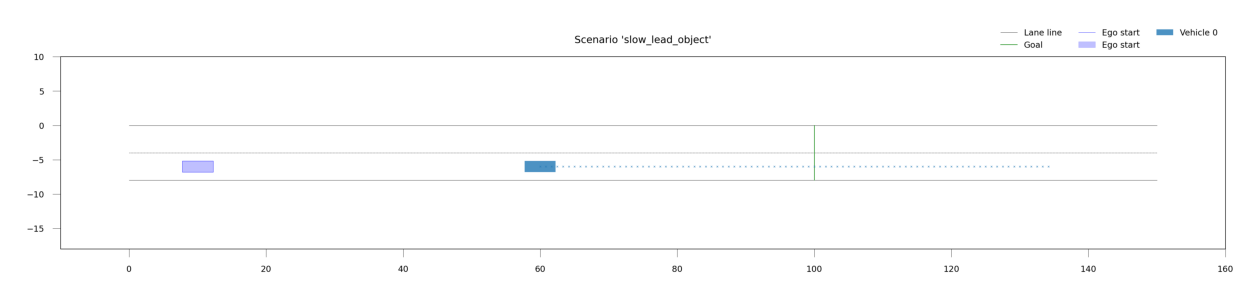

In [4]:
scenario_image_path = result_dir / f"{scenario.id}.png"

f, ax = plt.subplots(figsize=(16, 9))
ax.imshow(plt.imread(scenario_image_path))
ax.axes.set_axis_off()
plt.show()

It is also possible to plot the `Scenario` obejct into a `matplotlib` `Axes` through calling `.render(ax)`.

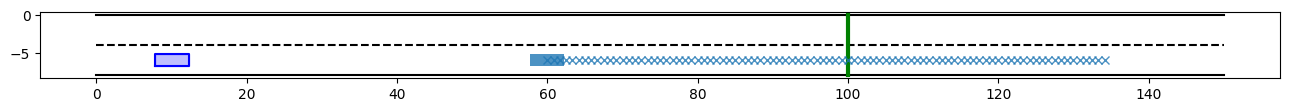

In [5]:
f, ax = plt.subplots(figsize=(16, 9))
scenario.render(ax)
ax.set_aspect("equal")
plt.show()

Because we want to run the scenario in `esmini`, we need have an OpenSCENARIO (`.xosc`) and an OpenDRIVE file (`.xodr`).

With `simple-scenario` it is just a matter of one line:

In [6]:
scenario.save(result_dir, mode="openx")

We find the saved files as:

In [7]:
print(f"{scenario.id}.xosc")
print(f"{scenario.id}.xodr")

slow_lead_object.xosc
slow_lead_object.xodr


We can now watch the scenario in esmini:

```bash
esmini --osc ./result_dir/static_lead_object.xosc
```

![](./assets/esmini_screenshot.jpg)

Let's next walk through the example step by step.

### Road

First, we create our two-lane straight road.

* A road is modelled by a `Road` object in `simple-scenario`.
* Each `Road` consists of a list of `RoadSegment`s. In our case, we want the `StraightSegment`, which can be defined by just a `length` in m.
* We also need to define a `goal_position` in our road, which is the position our ego vehicle wants to reach. In our case, we just assume that this `goal_position` is at `250 m` along the road.

In [8]:
# Create road
straight_road = Road(
    n_lanes=2,
    lane_width=4,  # in m
    segments=[
        StraightSegment(
            length=150,  # in m

        )
    ],
    goal_position=100
)

Similar to how we rendered the whole `Scenario`, we can also just render a `Road`:

In [9]:
road_plot_name = "straight_road"
straight_road.render(result_dir, plot_name=road_plot_name)

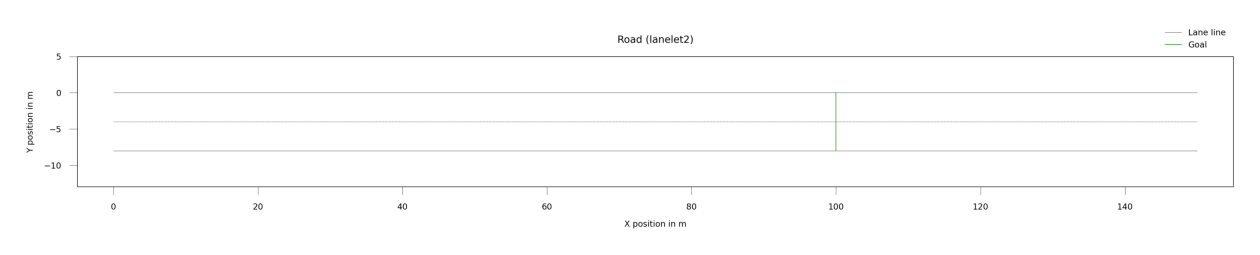

In [10]:
road_image_path = result_dir / f"{road_plot_name}.png"

f, ax = plt.subplots(figsize=(16, 9))
ax.imshow(plt.imread(road_image_path))
ax.axes.set_axis_off()
plt.show()

We can see that our road is straight, `150 m` long and has two lanes. The driving direction is from left to right. At `100 m`, we can see the goal line.

In the background, the `simple-scenario` has created a Lanelet2 map of the road with two lanelets. The IDs of the lanelets start by `1000` from the right (in driving direction).

I.e., the lower lane here has the ID `1000` and the upper one `1001`.

### EgoConfiguration

Next, let's define the starting conditions of the ego vehicle by using creating a `EgoConfiguration` object.

We need to make sure that our ego vehicle is starting on the map. Let's spawn it at `10 m` from the start of the road on the right lane in driving direction.

We need to define give the lanelet ID (`lanelet_id`), the starting position (in curvilinear coordinates `s0` and `t0` relative to the centerline of the lanelet) and the starting speed (`v0` in `m/s`).

In [11]:
from simple_scenario import EgoConfiguration

ego_config = EgoConfiguration(
    lanelet_id=1000,
    s0=10,
    t0=0,
    v0=80 / 3.6,  # in m/s
)

The `EgoConfiguration` also offers a `render()` method.

However, we cannot use it directly after instantiating the `EgoConfiguration` object. The reason is that the `EgoConfiguration` is defined relative to a `Road`. Therefore, the absolute coordinates of the `EgoConfiguration` are not known at this point. We need to *connect* it to a road coordinate frame. This connection is established by calling the `.compile()` method of the `EgoConfiguration` passing a `Road` object like so

In [12]:
ego_config.compile(road=straight_road)

&#128161; *If you are creating a `Scenario` object, this step is automatically being performed by the `Scenario`. You only need to do it manually if you want to work with the `EgoConfiguration` standalon* &#128161;

Let's render the compiled `EgoConfiguration` and have a look.

In [13]:
ego_config_plot_name = "ego_config"
ego_config.render(result_dir, plot_name=ego_config_plot_name)

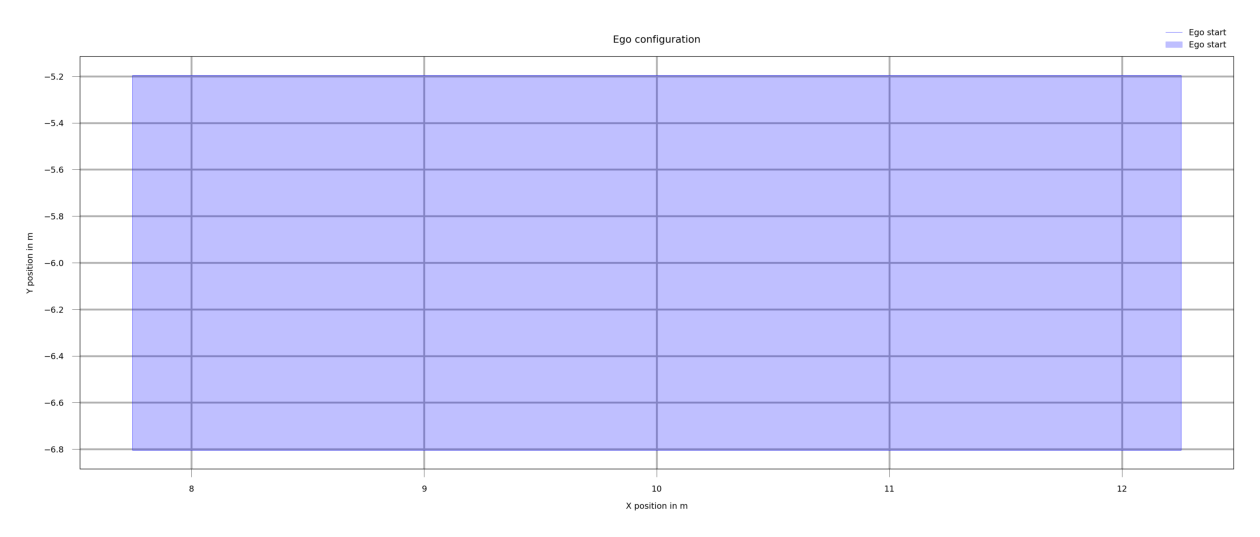

In [14]:
ego_config_image_path = result_dir / f"{ego_config_plot_name}.png"

f, ax = plt.subplots(figsize=(16, 9))
ax.imshow(plt.imread(ego_config_image_path))
ax.axes.set_axis_off()
plt.show()

It appears as a blue rectangle at the `10 m` position on the road.

### Vehicle

A vehicle is modelled by a `Vehicle` object.

We have to define
* an ID,
* the lanelet's ID,
* the starting position in curvilinear coordinates relative to the lanelet's centerline,
* and the starting velocity.

There are more possibilities to define the dynamic behaviour of the vehicle (e.g., acceleration profile, lane changes).

In [15]:
# Create vehicle
vehicle = Vehicle(
    vehicle_id=0,
    lanelet_id=1000,
    s0=ego_config.s0 + 50,  # 50 m ahead of ego
    t0=0,
    v0=30 / 3.6,  # slower speed
)

Similarly to the `EgoConfiguration`, the `Vehicle` is also defined relative to a `Road` and must therefore be *compiled* by calling the `.compile()` metod before using it standalone. A `Vehicle` can also be plotted by calling the `.render()` method.

### Scenario

We create the scenario by combining all the objects:

* Our `Road` object,
* our `EgoConfiguration` object,
* our list of `Vehicle` objects,
* the duration of the scenario in `s`,
* and the time step `dt`.

In [16]:
# Create scenario
scenario = Scenario(
    scenario_id="slow_lead_object",
    road=straight_road,
    ego_configuration=ego_config,
    vehicles=[vehicle],
    dt=0.1,  # in s
    duration=9,  # in s
)

## Creating a scenario from a config

Each `Scenario` object can be completely defined by a `config` that is automatically generated during scenario creation and we can access it through the `.config` property:

In [17]:
scenario.config

{'scenario_id': 'slow_lead_object',
 'road': {'n_lanes': 2,
  'lane_width': 4,
  'segments': [{'length': 150, 'heading': 0.0}],
  'speed_limit': 120,
  'goal_position': 100,
  'x0': 0,
  'y0': 0},
 'ego_configuration': {'lanelet_id': 1000,
  's0': 10,
  't0': 0,
  'v0': 22.22222222222222,
  'vehicle_type_name': 'medium'},
 'vehicles': [{'vehicle_id': 0,
   'lanelet_id': 1000,
   's0': 60,
   't0': 0,
   'v0': 8.333333333333334,
   'a0': 0,
   'a_delay': 0,
   'a_profile': 'constant',
   'lc_direction': 0,
   'lc_delay': 0,
   'lc_duration': 3,
   'lc_type': 'polynomial',
   'lc_vy': 0,
   'vehicle_type_name': 'medium'}],
 'duration': 9,
 'dt': 0.1}

The `config` holds all relevant information needed to (re)create the scenario. Therefore, a `Scenario` object can neatly be saved as a `config` by

In [18]:
scenario.save(result_dir)  # or scenario.save(result_dir, mode="config")

We can now create a copy of the scenario from the config.

Either by directly passing the `config` `dict` to the `Scenario.from_config()` method

In [19]:
scenario_copy1 = Scenario.from_config(scenario.config)

or by passing a path to a `config` `.json` to the `Scenario-from_file()` method

In [20]:
scenario_copy2 = Scenario.from_config_file(result_dir / f"{scenario.id}.json")

Instead of these two methods, we can also use the `Scenario.from_x()`, which will automatically find out whether we input a `dict` or a path to a `.json`

In [21]:
scenario_copy1b = Scenario.from_x(scenario.config)
scenario_copy2b = Scenario.from_x(result_dir / f"{scenario.id}.json")

The `Scenario.from_x()` method also allows a few other possibilities. One of them is to input a `Scenario` object. This allows efficient and seamless handover of already created `Scenario` objects between multiple modules without saving and loading in between.

A typical module working with `Scenario` objects looks like this

In [22]:
class MyModule:
    def __init__(self, scenario: dict | str | Path | Scenario) -> None:
        self._scenario = Scenario.from_x(scenario)

We can create instances of `MyModule` by passing a `dict`, a path to a `.json` or a `Scenario` object.

## More resources
Please have a look at the other Notebooks in the `tutorials/` folder or directly in the `test/` folder to find out more details about the usage of `simple-scenario`.